In [1]:
# ONA for Python - Noise reduction in Black Carbon data | version 02 (June 2020)

# ONA is the Optimized Noise reduction Averaging (ONA) algorithm developed by Hagler et al. (2011) to reduce the occurence of negative values of BC data while preserving the significant dynamics trends in the time series. 
# More information about ONA can be found in:

# Hagler GSW, Yelverton TLB, Vedantham R, Hansen ADA, Turner JR (2011) Post-processing Method to Reduce Noise while Preserving High Time Resolution in Aethalometer Real-time Black Carbon Data. Aerosol and Air Quality Research 11, 539–546. doi: 10.4209/aaqr.2011.05.0055

# The original algorithm was developed in MatLab code and this script aims to implement it in Python code.

# The script is available at:
# https://github.com/ncanha/ONA-algorithm-in-Python-for-BC-data-noise-reduction

In [2]:
# This program will look for positive (and final) changes in ATN throughout the data. This code
# anticipates that a variable named “BC_ONA” has already been created and has the following
# columns – 1) serial timestamp, 2) original BC concentrations, and 3) original ATN values.

In [3]:
# The example used in this code is regarding BC data obtained by a microAeth® AE51 (from ARTHLABS) 
# in a monitoring campaign in Greeland.

In [4]:
# Upload the analysis packages:

import numpy as np

In [5]:
import matplotlib.pyplot as plot

In [6]:
import csv

In [7]:
import time

In [8]:
import pandas as pd

In [9]:
# Check your working folder by using "pwd" and then "cd 'path'" to enter in the desired folder
# the raw csv datafile should be in the working folder

In [10]:
pwd

'C:\\Users\\Nuno Canha\\Desktop\\Python\\Geo\\Notebooks'

In [11]:
cd C:\Users\Nuno Canha\Desktop\Python\BC\Test

C:\Users\Nuno Canha\Desktop\Python\BC\Test


In [12]:
pwd

'C:\\Users\\Nuno Canha\\Desktop\\Python\\BC\\Test'

In [13]:
# Preparing data

fields = [] 
rows = [] 

In [14]:
with open('2017_BC_ONA_966.csv') as f:
    csvreader = csv.reader(f) 
    fields = next(csvreader)
    
    # Extracting each data row one by one 
    for row in csvreader: 
        rows.append(row)

In [15]:
data = np.array(rows)
b= []
data_times =[]
for i in range(len(data[:,0])):
    a=pd.to_datetime(data[i,0])
    b.append(a)
    
    # Time as posix
    data_times.append(time.mktime(a.timetuple()))

In [16]:
# First column is datetime:
data_times = np.array(data_times)

# Second column is black carbon data (BC):
bc = data[:,1]

# Third column is attenuation data (atn):
atn = data[:,2]

# Create three column BC_ONA matrix: 
BC_ONA = np.array([data_times,bc,atn])
BC_ONA = BC_ONA.transpose()

In [17]:
# Create new variable
BC_ONA_ATN=BC_ONA

BC_ONA_ATN

array([['1496776680.0', '-12', '4.589'],
       ['1496776740.0', '12', '4.59'],
       ['1496776800.0', '60', '4.591'],
       ...,
       ['1498759200.0', '4', '11.95'],
       ['1498759500.0', '31', '11.954'],
       ['1498759800.0', '-6', '11.953']], dtype='<U32')

In [18]:
# Find filter change points
temp = np.zeros([len(BC_ONA)-1,1])
for i in range(len(BC_ONA)-1):
    temp[i,0] = abs(float(BC_ONA_ATN[i+1,2])-float(BC_ONA_ATN[i,2]))
temp1= np.array(np.where(temp[:,0]>30))
if temp1.size != 0 :
    filtchange = np.array([0])
    filtchange = np.append(filtchange,temp1)
    filtchange = np.append(filtchange,len(BC_ONA_ATN))
else:
    filtchange = np.array([[0],[len(BC_ONA_ATN)]])
del i,temp1

In [19]:
# Check the new variable "temp" that contains the ATN changes between BC measures
temp

array([[0.001],
       [0.001],
       [0.002],
       ...,
       [0.001],
       [0.004],
       [0.001]])

In [20]:
len(temp)

10602

In [21]:
len(BC_ONA_ATN)

10603

In [22]:
# Define the ATN default incremental value
delATN=0.05

In [23]:
# Calculate smoothed BC
temp = np.zeros([len(BC_ONA_ATN),4])
temp[:,:-1] = BC_ONA_ATN
BC_ONA_ATN = temp
del temp
BC_ONA_ATN[:,3] = 1
temp = np.array([])
for i in range(len(BC_ONA_ATN[:,2])):
    if BC_ONA_ATN[i,2] != '-':
        temp2 = float(BC_ONA[i,2]) 
        temp = np.append(temp,temp2)  
        del temp2
for k in range(len(filtchange)-1):
    j = filtchange[k] # Set to first point after filter change
    j = int(j)
    for i in range(j,len(BC_ONA_ATN)):
        if j<filtchange[k+1]:
            if i==j:
                des_ind =np.where(temp[j:len(BC_ONA_ATN)]<=(temp[j]+delATN))
                temp2 = des_ind[-1]
                # des_ind = des_ind[-1]
                # if len(des_ind) == 0:
                if len(temp2) != 0:
                    
                    # Calculated smoothed new BC
                    BC_ONA_ATN[j:temp2[-1]+j+1,1]=np.nanmean(BC_ONA_ATN[j:temp2[-1]+j+1,1])      
                    
                    # Calculate averaging period
                    BC_ONA_ATN[j:temp2[-1]+j+1,3]=len(BC_ONA_ATN[j:temp2[-1]+j+1,1])
                    j = j+temp2[-1]+1
                else:
                    j = j+1
del filtchange

In [24]:
# The variable "BC_ONA_ATN" contains now 4 different collumns: "Time" (as posix), "Corrected BC", "ATN" and "points average"
BC_ONA_ATN

array([[1.49677668e+09, 2.31219512e+01, 4.58900000e+00, 8.20000000e+01],
       [1.49677674e+09, 2.31219512e+01, 4.59000000e+00, 8.20000000e+01],
       [1.49677680e+09, 2.31219512e+01, 4.59100000e+00, 8.20000000e+01],
       ...,
       [1.49875920e+09, 2.77777778e+01, 1.19500000e+01, 9.00000000e+00],
       [1.49875950e+09, 2.77777778e+01, 1.19540000e+01, 9.00000000e+00],
       [1.49875980e+09, 2.77777778e+01, 1.19530000e+01, 9.00000000e+00]])

In [25]:
# METRICS OF SMOOTHING PERFORMANCE 
# The code from this point forwards only displays the results and does not do any data alteration.

In [26]:
#1. Reduction of negatives - fraction in original vs. remaining
temp2 = 0
temp3 = 0

for i in range(len(BC_ONA[:,1])):
    if BC_ONA_ATN[i,1] != '':
        if float(BC_ONA[i,1])<0:
            temp2 += 1
    if BC_ONA_ATN[i,1] != '-':
            if float(BC_ONA_ATN[i,1])<0:
             temp3 += 1     

numneg_org=temp2/len(BC_ONA[:,1])
numneg_filt=temp3/len(BC_ONA[:,1])
del temp2,temp3
print("Fraction of negative values in original dataset = ",numneg_org)
print("Fraction of negative values after ONA correction = ",numneg_filt)
del numneg_org,numneg_filt

Fraction of negative values in original dataset =  0.30104687352636045
Fraction of negative values after ONA correction =  0.0


BC Noise reduction (from to, in ng.m-3): [27.82644784  0.17620767]


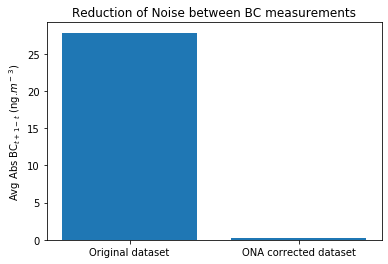

In [27]:
#2. Reduction of noise

temp = np.zeros([len(BC_ONA)-1,2])
for i in range(len(BC_ONA)-1):
    if BC_ONA_ATN[i,1] != '' and BC_ONA_ATN[i+1,1] != '':
        temp[i,0]=abs(float(BC_ONA[i+1,1])-float(BC_ONA[i,1]))
    if BC_ONA_ATN[i,1] != '-' and BC_ONA_ATN[i+1,1] != '-':
        temp[i,1]=abs(float(BC_ONA_ATN[i+1,1])-float(BC_ONA_ATN[i,1]))

noise = np.array([np.nanmean(temp[:,0]),np.nanmean(temp[:,1])])
langs = ['Original dataset','ONA corrected dataset']
fig = plot.figure()
plot.bar(langs,noise)
plot.title ('Reduction of Noise between BC measurements')
plot.ylabel('Avg Abs BC$_{t+1 - t}$ (ng.$m^-$$^3$)')
plot.rcParams['figure.figsize']=[12,6]
plot.savefig('Figure 1 - Noise Reduction.png')

print('BC Noise reduction (from to, in ng.m-3):', noise)

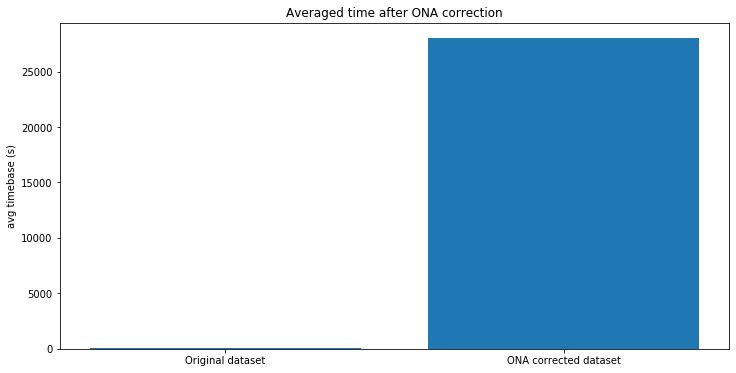

In [28]:
#3. Averaging interval and histogram of points averaged

time_inc = abs(float(BC_ONA[1,0])-float(BC_ONA[0,0]))
temp = BC_ONA_ATN[:,3].astype(np.float)
timeavg = np.array([time_inc,np.nanmean(temp)*time_inc])
fig2 = plot.figure()
plot.title ('Averaged time after ONA correction')
plot.bar(langs,timeavg)
plot.ylabel('avg timebase (s)')
plot.savefig('Figure 2 - Averaged time after ONA correction.png')

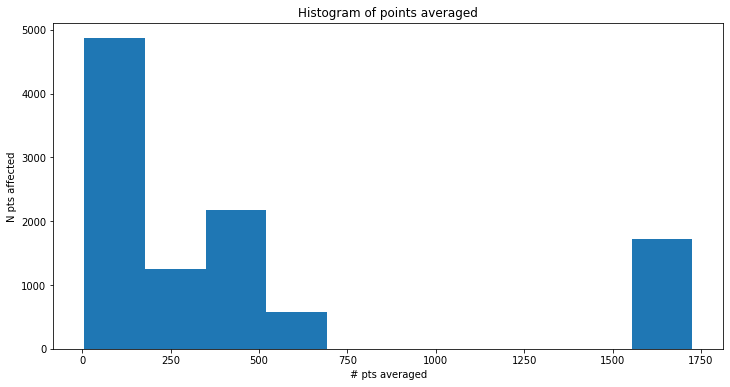

In [29]:
del time_inc,temp,timeavg
fig3 = plot.figure()
plot.hist(BC_ONA_ATN[:,3], bins = 10)
plot.title ('Histogram of points averaged')
plot.xlabel('# pts averaged')
plot.ylabel('N pts affected')
plot.savefig('Figure 3 - Histogram of points averaged.png')

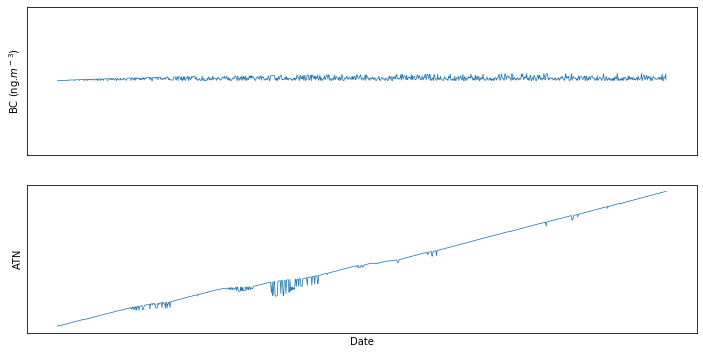

In [30]:
#4. Before - top figure BC time series, bottom figure ATN time series

fig4 = plot.figure()

# posix times and datetimes
plot.subplot(211)
yticks = [-2000,0,2000]
plot.plot(BC_ONA[::10,0], BC_ONA[::10,1],linewidth=0.75)
plot.yticks(yticks)
plot.ylabel('BC (ng.$m^-$$^3$)')
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# posix times:
plot.subplot(212)
plot.plot(BC_ONA[::10,0], BC_ONA[::10,2],linewidth=0.75)
plot.ylabel('ATN')
plot.xlabel('Date')
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

plot.savefig('Figure 4 - Before BC and ATN time series.png')

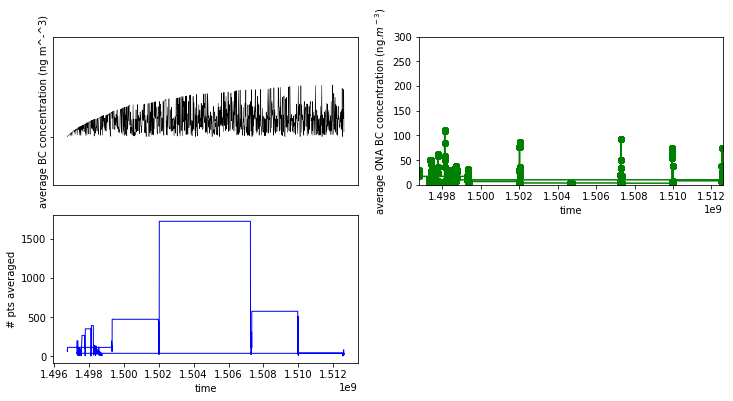

In [31]:
#5 After - top figure BC and BC-ONA time series, bottom figure averaging time
fig5 = plot.figure()
plot.subplot(221)
yticks = [-2000,0,2000]
plot.yticks(yticks)
plot.plot(BC_ONA[::10,0], BC_ONA[::10,1],color ='black',linewidth=0.5)
plot.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=True, labelleft=False)
plot.ylabel('average BC concentration (ng m^-^3)')
plot.axis('equal')
plot.subplot(222)

plot.plot(BC_ONA_ATN[:,0], BC_ONA_ATN[:,1],color ='green', marker='o')
plot.xlabel('time')
plot.axis([min(BC_ONA_ATN[:,0]), max(BC_ONA_ATN[:,0]),0,300])
plot.ylabel('average ONA BC concentration (ng.$m^-$$^3$)')

plot.subplot(223)
plot.plot(BC_ONA_ATN[:,0], BC_ONA_ATN[::,3],color ='blue',linewidth=1)
plot.xlabel('time')
plot.ylabel('# pts averaged')

plot.savefig('Figure 5 - BC and BC-ONA time series.png')

In [32]:
# Conversion of Numpy array to Pandas dataframe of BC_ONA_ATN
BC_ONA_ATN

array([[1.49677668e+09, 2.31219512e+01, 4.58900000e+00, 8.20000000e+01],
       [1.49677674e+09, 2.31219512e+01, 4.59000000e+00, 8.20000000e+01],
       [1.49677680e+09, 2.31219512e+01, 4.59100000e+00, 8.20000000e+01],
       ...,
       [1.49875920e+09, 2.77777778e+01, 1.19500000e+01, 9.00000000e+00],
       [1.49875950e+09, 2.77777778e+01, 1.19540000e+01, 9.00000000e+00],
       [1.49875980e+09, 2.77777778e+01, 1.19530000e+01, 9.00000000e+00]])

In [33]:
Final_BC_ONA = pd.DataFrame({'Timestamp': BC_ONA_ATN[:,0],'BC ONA': BC_ONA_ATN[:,1],'ATN': BC_ONA_ATN[:,2],'Points averaged': BC_ONA_ATN[:,3],})

In [34]:
Final_BC_ONA

,Timestamp,BC ONA,ATN,Points averaged
0,1.496777e+09,23.121951,4.589,82.0
1,1.496777e+09,23.121951,4.590,82.0
2,1.496777e+09,23.121951,4.591,82.0
3,1.496777e+09,23.121951,4.593,82.0
4,1.496777e+09,23.121951,4.594,82.0
...,...,...,...,...
10598,1.498759e+09,27.777778,11.946,9.0
10599,1.498759e+09,27.777778,11.949,9.0
10600,1.498759e+09,27.777778,11.950,9.0
10601,1.498760e+09,27.777778,11.954,9.0


In [35]:
# Check the number of occurencies of negative concentrations of BC:

neg=Final_BC_ONA[['BC ONA']].agg(lambda x: sum(x < 0)).sum()

In [36]:
neg

0

In [37]:
# Total number of concentrations values available for BC:
total=len(Final_BC_ONA['BC ONA'])
print(total)

10603


In [38]:
# Calculate the percentage of BC negative values:
pneg = neg/total*100
print("The percentage of negative BC values in the dataset is", pneg.round(0).astype(int), "%." )

The percentage of negative BC values in the dataset is 0 %.


In [39]:
# Conversion of timestamp from Posix to Year-Month-Day Hour:Minute
Final_BC_ONA['Timestamp'] = pd.to_datetime(Final_BC_ONA['Timestamp'],unit='s', dayfirst=True )
Final_BC_ONA

,Timestamp,BC ONA,ATN,Points averaged
0,2017-06-06 19:18:00,23.121951,4.589,82.0
1,2017-06-06 19:19:00,23.121951,4.590,82.0
2,2017-06-06 19:20:00,23.121951,4.591,82.0
3,2017-06-06 19:21:00,23.121951,4.593,82.0
4,2017-06-06 19:22:00,23.121951,4.594,82.0
...,...,...,...,...
10598,2017-06-29 17:50:00,27.777778,11.946,9.0
10599,2017-06-29 17:55:00,27.777778,11.949,9.0
10600,2017-06-29 18:00:00,27.777778,11.950,9.0
10601,2017-06-29 18:05:00,27.777778,11.954,9.0


In [40]:
# This conversion of the timestamp did not works properly (problems with days/months). 
Final_BC_ONA.head(6178)

,Timestamp,BC ONA,ATN,Points averaged
0,2017-06-06 19:18:00,23.121951,4.589,82.0
1,2017-06-06 19:19:00,23.121951,4.590,82.0
2,2017-06-06 19:20:00,23.121951,4.591,82.0
3,2017-06-06 19:21:00,23.121951,4.593,82.0
4,2017-06-06 19:22:00,23.121951,4.594,82.0
...,...,...,...,...
6173,2017-11-06 12:58:00,6.637965,6.586,511.0
6174,2017-11-06 12:59:00,6.637965,6.587,511.0
6175,2017-11-06 13:00:00,6.637965,6.588,511.0
6176,2017-11-06 13:01:00,6.637965,6.587,511.0


In [41]:
# Therefore, in order to avoid any problems with dates, the original timestamp from the initial input csv will be used.

In [42]:
# Histogram of ONA BC data

In [43]:
Hist_BC_ONA=Final_BC_ONA[['BC ONA']]

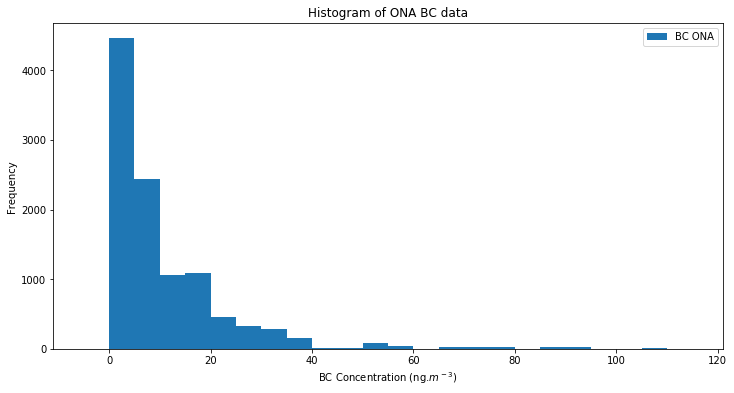

In [44]:
fig6 = Hist_BC_ONA.plot.hist(range=[-5, 115],bins=[-5, 0,5,10,15, 20,25, 30,35, 40,45, 50,55,60,65,70,75,80,85,90,95, 100, 105, 110, 115], title = 'Histogram of ONA BC data')
fig6.set_xlabel('BC Concentration (ng.$m^-$$^3$)')

# To save the figure
plot.savefig('Figure 6 - Histogram of ONA BC data')

In [45]:
# Check the histogram using a narrow timeframe:

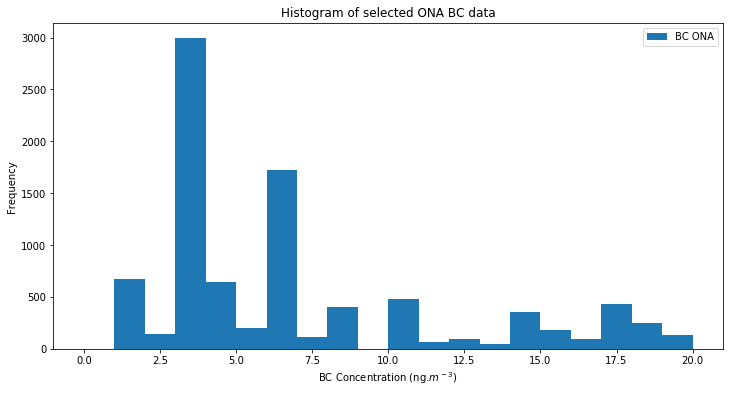

In [46]:
fig7 = Hist_BC_ONA.plot.hist(range=[0, 20], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],title = 'Histogram of selected ONA BC data')
fig7.set_xlabel('BC Concentration (ng.$m^-$$^3$)')

# To save the figure
plot.savefig('Figure 7 - Histogram of selected ONA BC data')

In [47]:
# Goal: compare BC concentrations before and after ONA correction

In [48]:
# 2.1. How to create a new dataframe (BC_ba: before and after) with the timestamp, BC data before and after correction, ATN and number of averaged points:

In [49]:
# 2.1.1. In order to avoid problems with the "timestamp", use the time collumn from the original csv file:
Initial_BC = pd.read_csv('2017_BC_ONA_966.csv', names=['Timestamp','BC','ATN'])

# 2.1.2. Create the new dataframe:
BC_ba = Initial_BC[['Timestamp']].join(Initial_BC[['BC']].join(Final_BC_ONA[['BC ONA']].join(Final_BC_ONA[['ATN']].join(Final_BC_ONA[['Points averaged']]))))

# 2.1.3. "BC" is not in the correct format (float) but it is in the "object" format. To change:
BC_ba["BC"] = BC_ba.BC.astype(float)

# 2.1.4. Check data types:
BC_ba.dtypes

Timestamp           object
BC                 float64
BC ONA             float64
ATN                float64
Points averaged    float64
dtype: object

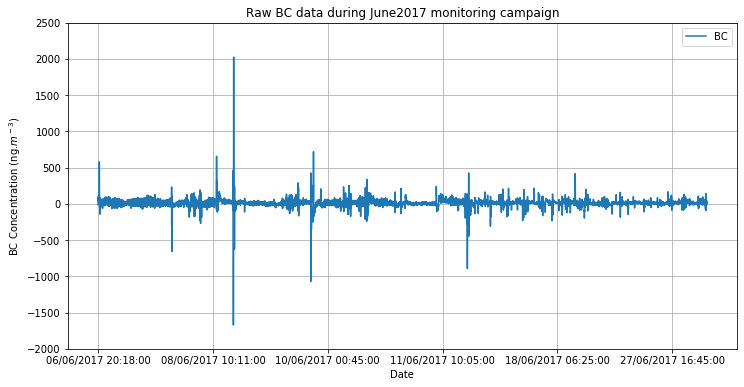

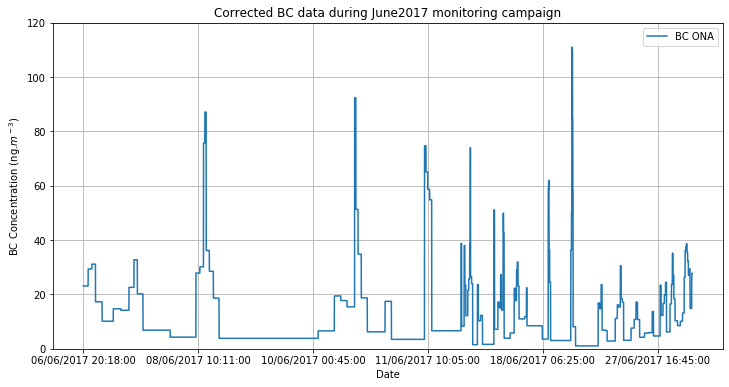

In [50]:
# 3. Graphs of BC before and after of ONA implementation:

fig8 = BC_ba.plot('Timestamp', 'BC', title = 'Raw BC data during June2017 monitoring campaign',
                   ylim=[-2000,2500])
fig8.set_xlabel('Date')
fig8.set_ylabel('BC Concentration (ng.$m^-$$^3$)')
fig8.grid(True)

# To save the figure
plot.savefig('Figure 8 - Raw BC data')

fig9 = BC_ba.plot('Timestamp', 'BC ONA', title = 'Corrected BC data during June2017 monitoring campaign',
                   ylim=[0,120])
fig9.set_xlabel('Date')
fig9.set_ylabel('BC Concentration (ng.$m^-$$^3$)')
fig9.grid(True)

# To save the figure
plot.savefig('Figure 9 - ONA corrected BC data')

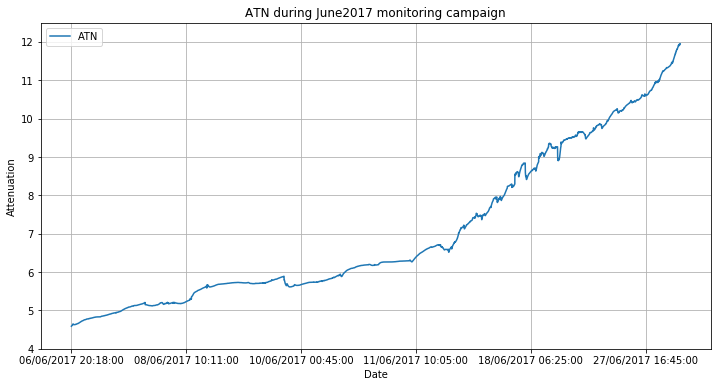

In [52]:
# 4. Graph of ATN

fig10 = BC_ba.plot('Timestamp', 'ATN', title = 'ATN during June2017 monitoring campaign',
                   ylim=[4,12.5])
fig10.set_xlabel('Date')
fig10.set_ylabel('Attenuation')
fig10.grid(True)

plot.savefig('Figure 10 - Attenuation during monitoring period')

In [53]:
# 5. Writing and saving file with all data

# This final csv file will have 5 different collumns: Timestamp, BC, BC ONA, ATN and Points averaged:

selection = BC_ba

output_selection = 'BC_ba_ONA_final.csv'

# Save dataframe to csv
selection.to_csv(output_selection, sep=',', index = False)

# "index = False" will remove the column index

In [54]:
# 6. Get descritive statistics summary only for "Temp":
stats = BC_ba[['BC','BC ONA','ATN','Points averaged']].describe()
print(stats)

                 BC        BC ONA           ATN  Points averaged
count  10603.000000  10603.000000  10603.000000     10603.000000
mean      11.251155     11.251155      7.017789       466.828162
std       53.961454     13.002676      1.960905       580.821353
min    -1672.000000      1.073604      4.589000         4.000000
25%       -4.500000      3.844728      5.654000        70.000000
50%       12.000000      6.599291      6.192000       268.000000
75%       29.000000     14.862069      8.657000       511.000000
max     2024.000000    111.000000     11.954000      1726.000000


In [55]:
# At the end of the script, the working folder should have the input file (csv), the output file with all data (csv) and 10 Figures regarding the 

In [56]:
# the performance of the ONA algorithm, raw and corrected data.

In [57]:
# The end!